# 2024-06-20 Finite Element Algebra

## Today's plan

* Introduction to quadrature
* libCEED abstraction
* Restriction to elements
* Nonlinear problems and the QFunction abstraction
* Advection-diffusion
* Stabilized methods for transport
* Other FE interfaces (deal.II)

In [65]:
using Plots
default(linewidth=3)
using LinearAlgebra
using SparseArrays
using FastGaussQuadrature

function my_spy(A)
    cmax = norm(vec(A), Inf)
    s = max(1, ceil(120 / size(A, 1)))
    spy(A, marker=(:square, s), c=:diverging_rainbow_bgymr_45_85_c67_n256, clims=(-cmax, cmax))
end

function vander_legendre_deriv(x, k=nothing)
    if isnothing(k)
        k = length(x) # Square by default
    end
    m = length(x)
    Q = ones(m, k)
    dQ = zeros(m, k)
    Q[:, 2] = x
    dQ[:, 2] .= 1
    for n in 1:k-2
        Q[:, n+2] = ((2*n + 1) * x .* Q[:, n+1] - n * Q[:, n]) / (n + 1)
        dQ[:, n+2] = (2*n + 1) * Q[:,n+1] + dQ[:,n]
    end
    Q, dQ
end

function febasis(P, Q, quadrature=gausslegendre)
    x, _ = gausslobatto(P)
    q, w = quadrature(Q)
    Pk, _ = vander_legendre_deriv(x)
    Bp, Dp = vander_legendre_deriv(q, P)
    B = Bp / Pk
    D = Dp / Pk
    x, q, w, B, D
end

function L2_galerkin(P, Q, f)
    x, q, w, B, _ = febasis(P, Q)
    A = B' * diagm(w) * B
    rhs = B' * diagm(w) * f.(q)
    u = A \ rhs
    x, u
end

L2_galerkin (generic function with 1 method)

# Quadrature

Our elements will be a line segment and we'll define quadrature on the standard line segment, $\hat K = (-1, 1)$. A quadrature is a set of points $q_i$ and weights $w_i$ such that
$$ \int_{-1}^1 f(x) \approx \sum_{i=1}^n w_i f(q_i) $$

In [24]:
default(linewidth=4)
function quad_trapezoid(n)
    q = LinRange(-1, 1, n)
    w = 2 * ones(n) / (n - 1)
    w[[1,end]] ./= 2
    q, w
end

function plot_quad_accuracy(f, F, quad)
    ns = 2 .^ (2:7)
    exact = F(1) - F(-1)
    function err(n)
        q, w = quad(n)
        w' * f.(q) - exact
    end
    errors = [abs.(err(n)) for n in ns]
    plot(ns, errors, marker=:auto, label=quad)
    plot!(ns, ns.^(-2), xscale=:log10, yscale=:log10)    
end

plot_quad_accuracy (generic function with 1 method)

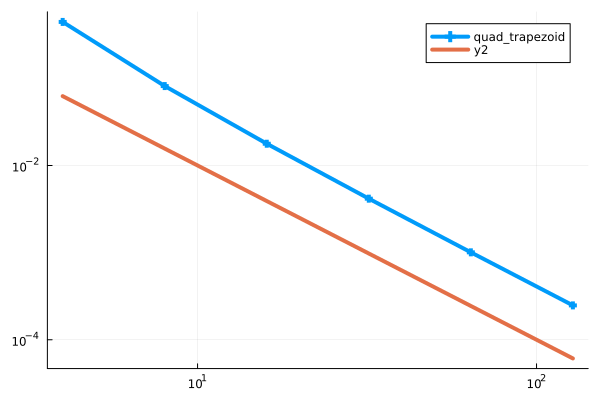

In [25]:
plot_quad_accuracy(exp, exp, quad_trapezoid)
plot_quad_accuracy(x -> 3*x^2, x -> x^3, quad_trapezoid)

# Integration via polynomial interpolation

* Pick some points $x_i$
* Evaluate the function there $f_i = f(x_i)$
* Find the polynomial that interpolates the data
* Integrate the polynomial

## What order of accuracy can we expect?
* What degree polynomials can be integrate exactly?

# Doing better: Gauss quadrature

Suppose a polynomial on the interval $[-1,1]$ can be written as

$$ P_n(x) q(x) + r(x) $$

where $P_n(x)$ is the $n$th Legendre polnomials and both $q(x)$ and $r(x)$ are polynomials of maximum degree $n-1$.

* Why is $\int_{-1}^1 P_n(x) q(x) = 0$?
* Can every polynomials of degree $2n-1$ be written in the above form?
* How many roots does $P_n(x)$ have on the interval?
* Can we choose points $\{x_i\}$ such that the first term is 0?

If $P_n(x_i) = 0$ for each $x_i$, then we need only integrate $r(x)$, which is done exactly by integrating its interpolating polynomial.  How do we find these roots $x_i$?

# Gauss-Legendre in code

1. Solve for the points, compute the weights
  * Use a Newton solver to find the roots. You can use the recurrence to write a recurrence for the derivatives.
  * Create a Vandermonde matrix and extract the first row of the inverse or (using more structure) the derivatives at the quadrature points.
2. Use duality of polynomial roots and matrix eigenvalues.
  * A fascinating mathematical voyage (topic of graduate linear algebra class).

In [21]:
function gauss_legendre(n)
    """Gauss-Legendre integration using Golub-Welsch algorithm"""
    beta = @. .5 / sqrt(1 - (2 * (1:n-1))^(-2))
    T = diagm(-1 => beta, 1 => beta)
    D, V = eigen(T)
    w = V[1,:].^2 * 2
    q = D
    q, w
end

gauss_legendre (generic function with 1 method)

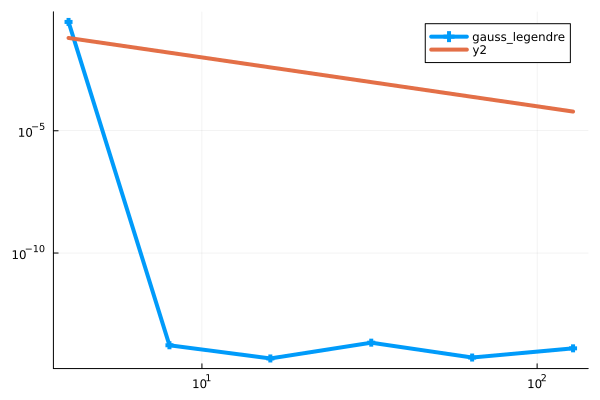

In [22]:
plot_quad_accuracy(exp, exp, gauss_legendre)
plot_quad_accuracy(x -> 11*x^10, x -> x^11, gauss_legendre)


# Legendre polynomials

In [84]:
function vander_legendre(x, k=nothing)
    if isnothing(k)
        k = length(x) # Square by default
    end
    m = length(x)
    Q = ones(m, k)
    Q[:, 2] = x
    for n in 1:k-2
        Q[:, n+2] = ((2*n + 1) * x .* Q[:, n+1] - n * Q[:, n]) / (n + 1)
    end
    Q
end

vander_legendre (generic function with 2 methods)

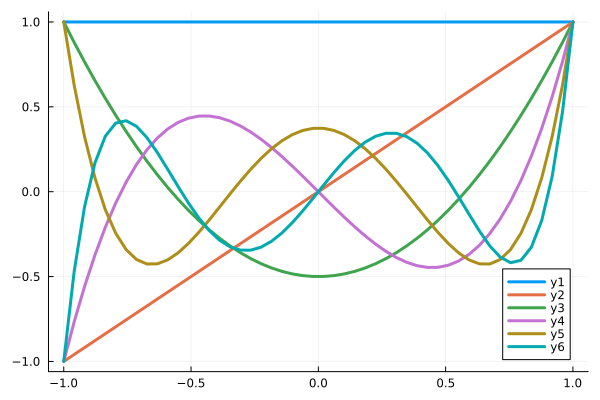

In [85]:
x = LinRange(-1, 1, 50)
P = vander_legendre(x, 6)
plot(x, P)

# Prime to nodal basis

A **nodal basis** $\{ \phi_j(x) \}$ is one that satisfies
$ n_i(\phi_j) = \delta_{ij} . $

We write $\phi_j$ in the prime basis by solving with the generalized Vandermonde matrix $V_{ij} = \langle n_i, p_j \rangle$,
$$ \phi_j(x) = \sum_k p_k(x) (V^{-1})_{k,j} . $$

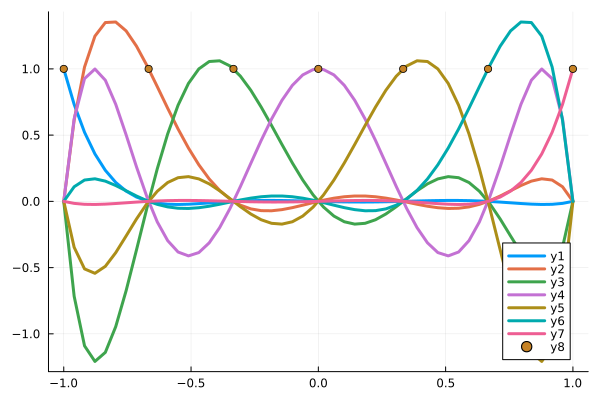

In [90]:
k = 7
xn = LinRange(-1, 1, k)
V = vander_legendre(xn)
xx = LinRange(-1, 1, 50)
Pxx = vander_legendre(xx, k)
Pn = Pxx / V
plot(xx, Pn)
scatter!(xn, one.(xn))

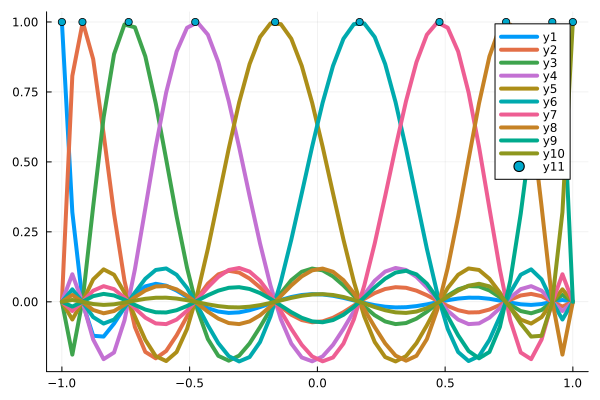

In [26]:
using FastGaussQuadrature
xn, _ = gausslobatto(k)
V = vander_legendre(xn)
Pn = Pxx / V
plot(xx, Pn)
scatter!(xn, one.(xn))

In [27]:
function vander_legendre_deriv(x, k=nothing)
    if isnothing(k)
        k = length(x) # Square by default
    end
    m = length(x)
    Q = ones(m, k)
    dQ = zeros(m, k)
    Q[:, 2] = x
    dQ[:, 2] .= 1
    for n in 1:k-2
        Q[:, n+2] = ((2*n + 1) * x .* Q[:, n+1] - n * Q[:, n]) / (n + 1)
        dQ[:, n+2] = (2*n + 1) * Q[:,n+1] + dQ[:,n]
    end
    Q, dQ
end

vander_legendre_deriv (generic function with 2 methods)

![](../img/libCEED-2-trim.svg)

# General form
$$ \int_\Omega v\cdot f_0(u, \nabla u) + \nabla v\cdot f_1(u, \nabla u) = 0, \quad \forall v$$
we discretize as
$$ \sum_e \mathcal E_e^T \Big( B^T W \left\lvert \frac{\partial x}{\partial X} \right\rvert f_0(\tilde u, \nabla \tilde u) + D^T \left(\frac{\partial X}{\partial x}\right)^{T} W \left\lvert \frac{\partial x}{\partial X} \right\rvert f_1(\tilde u, \nabla\tilde u) \Big) = 0 $$
where $\tilde u = B \mathcal E_e u$ and $\nabla \tilde u = \frac{\partial X}{\partial x} D \mathcal E_e u$ are the values and gradients evaluated at quadrature points.

## Isoparametric mapping

Given the reference coordinates $X \in \hat K \subset R^n$ and physical coordinates $x(X)$, an integral on the physical element can be written
$$ \int_{K = x(\hat K)} f(x) dx = \int_K \underbrace{\left\lvert \frac{\partial x}{\partial X} \right\rvert}_{\text{determinant}} f(x(X)) dX .$$

| Notation | Meaning |
|---------|:-------------|
| $x$ | physical coordinates |
| $X$ | reference coordinates |
| $\mathcal E_e$ | restriction from global vector to element $e$ |
| $B$ | values of nodal basis functions at quadrature ponits on reference element |
| $D$ | gradients of nodal basis functions at quadrature points on reference element|
| $W$ | diagonal matrix of quadrature weights on reference element |
| $\frac{\partial x}{\partial X} = D \mathcal E_e x $ | gradient of physical coordinates with respect to reference coordinates |
| $\left\lvert \frac{\partial x}{\partial X}\right\rvert$ | determinant of coordinate transformation at each quadrature point |
| $\frac{\partial X}{\partial x} = \left(\frac{\partial x}{\partial X}\right)^{-1}$ | derivative of reference coordinates with respect to physical coordinates |

# Finite element mesh and restriction

In [2]:
function fe1_mesh(P, nelem)
    x = LinRange(-1, 1, nelem+1)
    rows = Int[]
    cols = Int[]
    for i in 1:nelem
        append!(rows, (i-1)*P+1:i*P)
        append!(cols, (i-1)*(P-1)+1:i*(P-1)+1)
    end
    x, sparse(cols, rows, ones(nelem*P))'
end
P, nelem = 4, 3
x, E = fe1_mesh(P, nelem)
E

12×10 Adjoint{Float64, SparseMatrixCSC{Float64, Int64}} with 12 stored entries:
 1.0   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅   1.0   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅   1.0   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅   1.0   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅   1.0   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅   1.0   ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅   1.0   ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   1.0   ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   1.0   ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   1.0   ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   1.0   ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   1.0

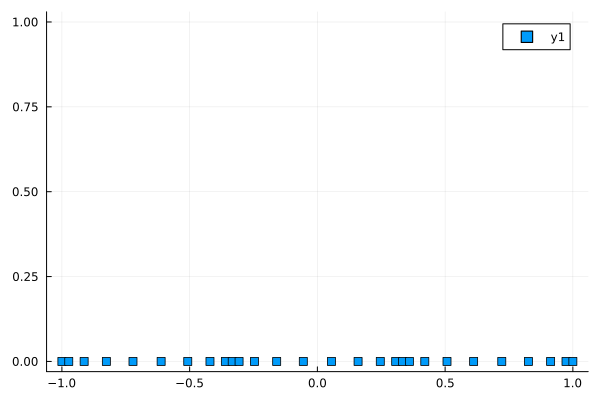

In [3]:
function xnodal(x, P)
    xn = Float64[]
    xref, _ = gausslobatto(P)
    for i in 1:length(x)-1
        xL, xR = x[i:i+1]
        append!(xn, (xL+xR)/2 .+ (xR-xL)/2 * xref[1+(i>1):end])
    end
    xn
end
xn = xnodal(x, 10)
scatter(xn, zero, marker=:square)

# Finite element building blocks

In [62]:
struct FESpace
    P::Int
    Q::Int
    nelem::Int
    x::Vector
    xn::Vector
    Et::SparseMatrixCSC{Float64, Int64}
    q::Vector
    w::Vector
    B::Matrix
    D::Matrix
    function FESpace(P, Q, nelem, quadrature=gausslegendre)
        x, E = fe1_mesh(P, nelem)
        xn = xnodal(x, P)
        _, q, w, B, D = febasis(P, Q, quadrature)
        new(P, Q, nelem, x, xn, E', q, w, B, D)
    end
end

In [5]:
# Extract out what we need for element e
function fe_element(fe, e)
    xL, xR = fe.x[e:e+1]
    q = (xL+xR)/2 .+ (xR-xL)/2*fe.q
    w = (xR - xL)/2 * fe.w
    E = fe.Et[:, (e-1)*fe.P+1:e*fe.P]'
    dXdx = ones(fe.Q) * 2 / (xR - xL)
    q, w, E, dXdx
end

fe = FESpace(3, 3, 5)
q, w, E, dXdx = fe_element(fe, 1);
@show q
@show sum(w)
E

q = [-0.9549193338482966, -0.8, -0.6450806661517035]
sum(w) = 0.3999999999999999


3×11 Adjoint{Float64, SparseMatrixCSC{Float64, Int64}} with 3 stored entries:
 1.0   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅   1.0   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅   1.0   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 

# Finite element residual assembly
$$ v^T F(u) \sim \int_\Omega v\cdot f_0(u, \nabla u) + \nabla v\cdot f_1(u, \nabla u) = 0, \quad \forall v$$
$$ \sum_e \mathcal E_e^T \Big( B^T W \left\lvert \frac{\partial x}{\partial X} \right\rvert f_0(\tilde u, \nabla \tilde u) + D^T \left(\frac{\partial X}{\partial x}\right)^{T} W \left\lvert \frac{\partial x}{\partial X} \right\rvert f_1(\tilde u, \nabla\tilde u) \Big) = 0 $$
where $\tilde u = B \mathcal E_e u$ and $\nabla \tilde u = \frac{\partial X}{\partial x} D \mathcal E_e u$ are the values and gradients evaluated at quadrature points.

In [99]:
kappa(x) = 0.6 .+ 0.4*sin(pi*x/2)
fq(q, u, Du) = 0*u .- 1, kappa.(q) .* Du
dfq(q, u, du, Du, Ddu) = 0*du, kappa.(q) .* Ddu

function fe_residual(u_in, fe, fq; bci=[1], bcv=[3.])
    u = copy(u_in); v = zero(u)
    u[bci] = bcv
    for e in 1:fe.nelem
        q, w, E, dXdx = fe_element(fe, e)
        B, D = fe.B, fe.D
        ue = E * u
        uq = B * ue
        Duq = dXdx .* (D * ue)
        f0, f1 = fq(q, uq, Duq)
        ve = B' * (w .* f0) + D' * (dXdx .* w .* f1)
        v += E' * ve
    end
    v[bci] = u_in[bci] - u[bci]
    #println("residual")
    v
end

fe_residual (generic function with 1 method)

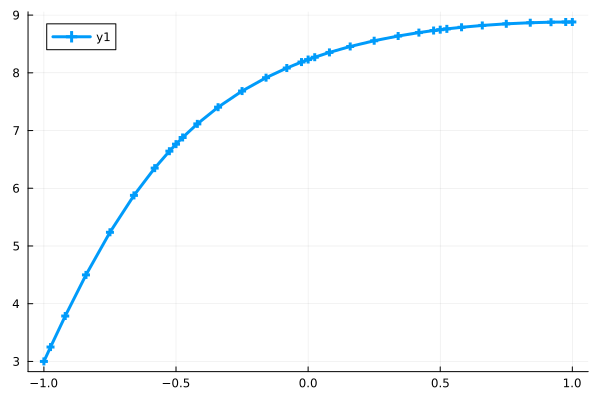

In [100]:
import NLsolve: nlsolve

fe = FESpace(9, 9, 4)
u0 = zero(fe.xn)
sol = nlsolve(u -> fe_residual(u, fe, fq), u0; method=:newton)
plot(fe.xn, sol.zero, marker=:auto)

# Finite element Jacobian assembly

$$ v^T F(u) \sim \int_\Omega v\cdot f_0(u, \nabla u) + \nabla v\cdot f_1(u, \nabla u) = 0, \quad \forall v$$
$$ v^T J(u) du \sim \int_\Omega v\cdot df_0(u, du, \nabla u, \nabla du) + \nabla v\cdot df_1(u, du, \nabla u, \nabla du) = 0, \quad \forall v$$

In [104]:
function fe_jacobian(u_in, fe, dfq; bci=[1], bcv=[1.])
    u = copy(u_in); u[bci] = bcv
    rows, cols, vals = Int[], Int[], Float64[]
    for e in 1:fe.nelem
        q, w, E, dXdx = fe_element(fe, e)
        B, D, P = fe.B, fe.D, fe.P
        ue = E * u
        uq = B * ue; Duq = dXdx .* (D * ue)
        K = zeros(P, P)
        for j in 1:fe.P
            du = B[:,j]
            Ddu = dXdx .* D[:,j]
            df0, df1 = dfq(q, uq, du, Duq, Ddu)
            K[:,j] = B' * (w .* df0) + D' * (dXdx .* w .* df1)
        end
        inds = rowvals(E')
        append!(rows, kron(ones(P), inds))
        append!(cols, kron(inds, ones(P)))
        append!(vals, vec(K))
    end
    A = sparse(rows, cols, vals)
    A[bci, :] .= 0; A[:, bci] .= 0
    A[bci,bci] = diagm(ones(length(bci)))
    A
end

fe_jacobian (generic function with 1 method)

In [105]:
sol = nlsolve(u -> fe_residual(u, fe, fq),
    u -> fe_jacobian(u, fe, dfq),
    u0;
    method=:newton)

Results of Nonlinear Solver Algorithm
 * Algorithm: Newton with line-search
 * Starting Point: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 * Zero: [3.0, 3.2489068364514937, 3.7866025435441726, 4.498814848889512, 5.2376180545041615, 5.876371962743226, 6.349142519283156, 6.642494349631555, 6.764133262981042, 6.879631421651573, 7.115473040131377, 7.404634884426794, 7.684402665284649, 7.915646155169686, 8.083315318822995, 8.186733580241315, 8.229591544010285, 8.270306080365378, 8.35358112320515, 8.45606535681658, 8.555603318009895, 8.637815828741978, 8.696882656901094, 8.732737079033674, 8.747380344456408, 8.761133060612707, 8.788624927614789, 8.820708255115848, 8.848737333728216, 8.867719802361721, 8.877213320982365, 8.880161019647838, 8.880475082672124]
 * Inf-norm of residuals: 0.000000
 * Iterations: 1
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)|

# Spy on the Jacobian

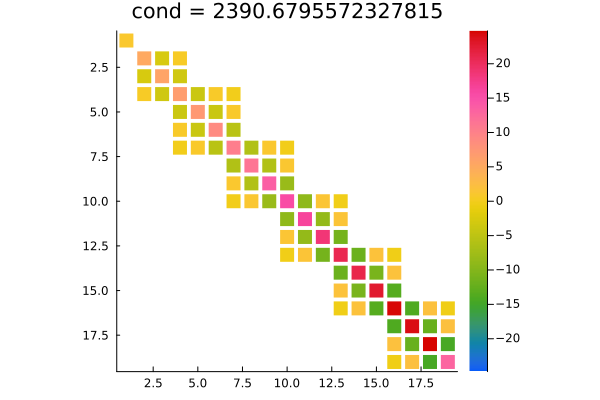

In [109]:
fe = FESpace(4, 6, 6)
u0 = zero(fe.xn)
J = fe_jacobian(u0, fe, dfq)
my_spy(J)
plot!(title="cond = $(cond(Matrix(J)))")

* What is interesting about this matrix structure?
  * What would the matrix structure look like for a finite difference method that is 6th order accurate?

# Mass matrices

$$ v^T M u \sim \int v u $$

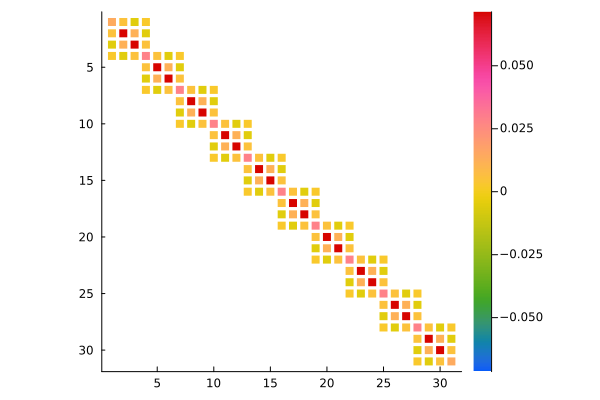

In [122]:
fe = FESpace(4, 4, 10)
u0 = zero(fe.xn)
function mass(q, u, du, Du, Ddu)
    df0 = du
    df1 = 0*du
    df0, df1
end
J = fe_jacobian(zero.(fe.xn), fe, mass, bci=[], bcv=[])
my_spy(J)
# cond(Matrix(J))

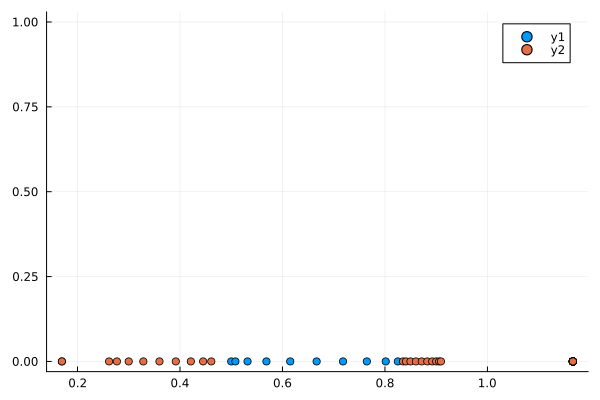

In [123]:
P = diagm(1 ./ diag(J))
e1 = eigvals(Matrix(P * J))
e2 = eigvals(Matrix(J) / maximum(J))
scatter([real.(e1) real.(e2)], [imag.(e1) imag.(e2)])

# Advection-diffusion (time independent)

\begin{align}
\mathbf w \cdot \nabla u - \nabla\cdot\big[ \kappa \nabla u \big] &= s & \int_\Omega v \mathbf w \cdot \nabla u + \int_\Omega \nabla v \cdot \kappa \nabla u  &= \int_\Omega v s, \forall v
\end{align}

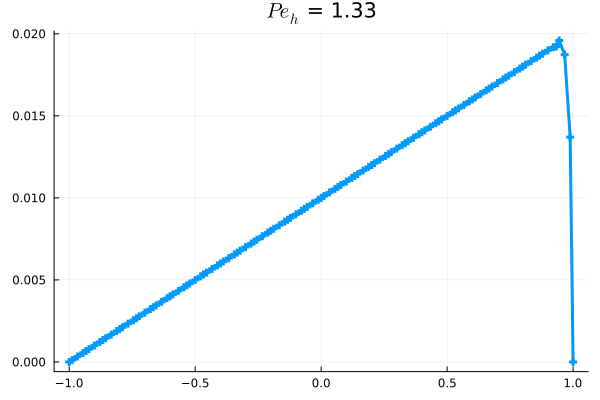

In [135]:
wind = 100; k = 1
fq(q, u, Du) = wind .* Du -one.(u), k * Du

P = 5; Q = P; nelem = 30; h = 2 / (P * nelem); Pe_h = wind * h / k
fe = FESpace(P, Q, nelem)
u0 = zero(fe.xn)
N = length(fe.xn)
sol = nlsolve(u -> fe_residual(u, fe, fq; bci=[1, N], bcv=[0, 0]), zero(fe.xn), method=:newton)
plot(fe.xn, sol.zero, marker=:auto, legend=:none, title="\$Pe_h\$ = $(round(Pe_h, digits=2))")

# Artificial diffusion and Streamline Upwinding

Observation: the residual is large where diffusion is needed.

$$\underbrace{\int_\Omega v \mathbf w \cdot \nabla u + \int_\Omega \nabla v \cdot \kappa \nabla u - \int_\Omega v s}_{\text{Galerkin}} + \int_\Omega (\mathbf w \cdot \nabla v) \tau^e \big(\underbrace{\mathbf w \cdot \nabla u - \nabla\cdot(\kappa\nabla u) - s}_{\text{strong form residual}}\big)$$

## Examine what this does to advection

$$(\mathbf w \cdot \nabla v)(\mathbf w \cdot \nabla u) = \nabla v (\mathbf w \otimes \mathbf w) \nabla u$$

This is "pencil" shaped diffusion, only along the streamline. If $\tau^e$ is chosen appropriately, this will be enough diffusion to get a Peclet number of about 1 when it needs it.

## Optimal stabilization
A nodally exact solution for 1D advection-diffusion.
$$ \tau^e = \frac{h}{2 \lVert \mathbf w \rVert} \Big( \coth Pe - \frac{1}{Pe} \Big)$$

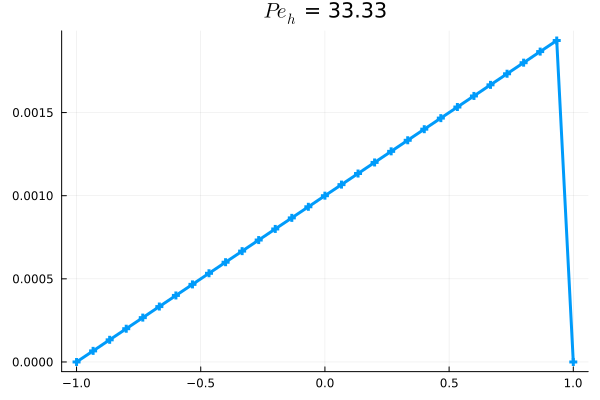

In [139]:
wind = 1000; k = 1
fq(q, u, Du) = wind .* Du - one.(u), k * Du + tau * wind.^2 .* Du

n = 30; h = 2 / n; Pe = abs(wind) * h / (2 * k)
tau = h / (2 * abs(wind)) * (coth(Pe) - 1 / Pe)
fe = FESpace(2, 2, n)
u0 = zero(fe.xn)
N = length(fe.xn)
sol = nlsolve(u -> fe_residual(u, fe, fq; bci=[1, N], bcv=[0, 0]), zero(fe.xn), method=:newton)
plot(fe.xn, sol.zero, marker=:auto, legend=:none, title="\$Pe_h\$ = $(round(Pe, digits=2))")

# Variational Multiscale key ideas

Suppose we have the strong and weak forms
\begin{align}
u_t + F(u) &= 0 & \langle v, u_t \rangle + a(v,u) &= 0
\end{align}
where $L = \partial F/\partial u$. For advection-diffusion, $L u = \mathbf w \cdot \nabla u - \nabla\cdot(\kappa \nabla u)$.

Decompose the solution into a resolved and oscillatory part $u = \bar u + \tilde u$ and similar for $v = \bar v + \tilde v$.
\begin{align}
\langle \bar v, \bar u_t + \tilde u_t \rangle + a(\bar v, \bar u + \tilde u) & = 0 \\
\langle \tilde v, \bar u_t + \tilde u_t \rangle + a(\tilde v, \bar u + \tilde u) & = 0 
\end{align}

We approximate via first order Taylor series
\begin{align}
a(\bar v, \bar u + \tilde u) &\approx a(\bar v, \bar u) + \langle \bar v, L \tilde u \rangle \\
&= a(\bar v, \bar u) + \langle L^* \bar v, \tilde u \rangle \\
a(\tilde v, \bar u + \tilde u) &\approx \langle \tilde v, F(\bar u) \rangle + \langle \tilde v, L \tilde u \rangle
\end{align}
where we prefer the forms in which $L$ or its adjoint, $L^*$, is applied to the smoother of the two functions.

## Subgrid ansatz
$\tilde u$ can be obtained by solving
$$\langle \tilde v, L \tilde u \rangle = -\langle \tilde v, \bar u_t + \tilde u_t + F(\bar u) \rangle$$
but these are all unresolved scales. Assuming quasistatic fluctuations $\tilde u_t = 0$, the ansatz $\tau \approx L^{-1}$ gives
$$\tilde u = -\tau (\bar u_t + F(\bar u))$$
and thus the stabilized form entirely in terms of resolved scales.
$$\underbrace{\langle \bar v, \bar u_t \rangle + a(\bar v, \bar u)}_{\text{Galerkin}} - \langle L^* \bar v, \tau (\bar u_t + F(\bar u)) \rangle$$
Expressions for $\tau$ can be obtained by local problems or Fourier analysis.

# Stabilized methods for advection-diffusion

\begin{align}
L u &= \mathbf w \cdot \nabla u - \nabla\cdot(\kappa \nabla u) &
L^* u &= -\mathbf w \cdot \nabla u - \nabla\cdot(\kappa \nabla u)
\end{align}

## Variational Multiscale [1998](https://doi.org/10.1016/S0045-7825(98)00079-6)

$$\underbrace{\langle \bar v, \bar u_t \rangle + a(\bar v, \bar u)}_{\text{Galerkin}} - \langle L^* \bar v, \tau (\bar u_t + F(\bar u)) \rangle$$
* Stabilization is not symmetric
* Involves diffusion operator applied to test function, but basis functions are only $C^0$ (discontinuous derivatives).
* Properly applied as a space-time method, not method of lines (so doesn't work with off-the-shelf ODE integrators).
* Explains preferred $L$ vs $L^*$ for hyperbolic systems with nonsymmetric flux Jacobian.

## Galerkin Least-Squares [1991](https://doi.org/10.1016/0045-7825(91)90041-4)
$$\langle \bar v, \bar u_t \rangle + a(\bar v, \bar u) + \langle L \bar v, \tau (\bar u_t + F(\bar u)) \rangle$$
* SPD stabilization (convenient for theory)
* A space-time method when done properly.
* Less accurate than VMS in practice.

## SUPG [1982](https://doi.org/10.1016/0045-7825(82)90071-8)
$$\langle \bar v, \bar u_t \rangle + a(\bar v, \bar u) - \langle L^*_{\text{adv}} \bar v, \tau (\bar u_t + F(\bar u)) \rangle$$

* [**Streamline upwind Petrov-Galerkin** is misleading](https://doi.org/10.1002/fld.1650071108)
* Easy to implement with method of lines
* **SU** variant even simpler; only first order.

# Time dependent problems

1. Start with a time dependent problem in strong form
$$ u_t + \nabla\cdot (\mathbf w u - \kappa \nabla u) = 0 .$$
2. Multiply by a test function $v$ and integrate
$$ \int_\Omega \Big[ v u_t + \nabla v\cdot \big(\kappa \nabla u - \mathbf w u \big) - vs \Big] = 0, \forall v.$$
3. Discretize and assemble
$$ M u_t + A u - s = 0$$
4. Convert to explicit ODE form
$$ u_t = M^{-1} (-A u + s). $$

* Mass matrix $M$ has the same sparsity pattern as the physics $A$ -- direct solve costs the same.
  * Finite element methods must be explicit?
* $M$ is usually much better conditioned than $A$; solve in less than 10 CG iterations with Jacobi preconditioning.
* Replace $M$ with a diagonal approximation
  * $\operatorname{diag}(M)$ is inconsistent
  * row sums = "lumping"
  * use collocated Lobatto quadrature

# Collocated quadrature

In [60]:
dfq_mass(q, u, du, Du, Ddu) = du, 0*Ddu

function fe_jacobian(u_in, fe, dfq; bci=[1], bcv=[1.])
    u = copy(u_in); u[bci] = bcv
    rows, cols, vals = Int[], Int[], Float64[]
    for e in 1:fe.nelem
        q, w, E, dXdx = fe_element(fe, e)
        B, D, P = fe.B, fe.D, fe.P
        ue = E * u 
        uq = B * ue; Duq = dXdx .* (D * ue)
        K = zeros(P, P)
        for j in 1:fe.P
            du = B[:,j]
            Ddu = dXdx .* D[:,j]
            df0, df1 = dfq(q, uq, du, Duq, Ddu)
            K[:,j] = B' * (w .* df0) + D' * (dXdx .* w .* df1)
        end
        inds = rowvals(E')
        append!(rows, kron(ones(P), inds))
        append!(cols, kron(inds, ones(P)))
        append!(vals, vec(K))
    end
    A = sparse(rows, cols, vals)
    A[bci, :] .= 0; A[:, bci] .= 0
    A[bci,bci] = diagm(ones(length(bci)))
    A
end

fe_jacobian (generic function with 1 method)

norm(J1 - diagm(diag(J1))) = 8.961917579818835e-17
norm(J2 - diagm(diag(J2))) = 0.07988743228160049
norm(sum(J2, dims = 2) - diag(J1)) = 2.6207532627416455e-16


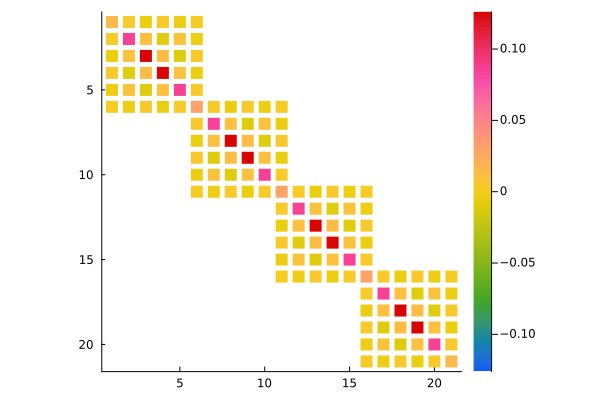

In [66]:
fe = FESpace(6, 6, 4, gausslobatto)
u0 = zero(fe.xn)
J1 = fe_jacobian(u0, fe, dfq_mass, bci=[], bcv=[])
fe = FESpace(6, 6, 4, gausslegendre)
J2 = fe_jacobian(u0, fe, dfq_mass, bci=[], bcv=[])
@show norm(J1 - diagm(diag(J1)))
@show norm(J2 - diagm(diag(J2)))
@show norm(sum(J2, dims=2) - diag(J1))
my_spy(J2)

# SUPG for time-dependent problems

$$\int_\Omega v \big( u_t + \mathbf w \cdot \nabla u \big) + \int_\Omega \nabla v \cdot \kappa \nabla u - \int_\Omega v s + \int_\Omega \tau^e (\mathbf w \cdot \nabla v) \big(u_t + \mathbf w \cdot \nabla u - \nabla\cdot(\kappa\nabla u) - s\big)$$

* There is a $u_t$ term in the stabilization, tested by a gradient of the test function. This means we can't create a simple explicit form
$$u_t = M^{-1} F(u)$$
* Some ad-hoc methods treat this term explicitly, which effectively lags this term. It can work, but limits the choice of time integrator and affects order of accuracy in time.
* One can use fully implicit methods with this formulation, usually written as $G(\dot u, u, t) = 0$. Generalized alpha (a second order scheme that can move continuously between midpoint and BDF2, which is L-stable) methods are popular.

* There is a strong  form $$\nabla\cdot(\kappa\nabla u)$$ appearing in stabilization.
* For linear elements, this is typically zero on each element.
  * Ignore the term (popular) or reconstruct it using neighbor cells (implementation complexity) and/or projection (extra work/communication).
* High order elements
  * If $\kappa$ is constant, $\kappa \nabla\cdot\nabla u$ can be implemented using second derivatives of the basis functions.
  * Or via projection
  * Should $\tau^e$ be constant or variable over the element?

# SUPG solver

In [163]:
wind = 1; k = 0
n = 200; h = 2 / n; Pe = abs(wind) * h / (2 * k)
tau = h / (2 * abs(wind)) * (coth(Pe) - 1 / Pe)
dfq_supg_mass(q, u, du, Du, Ddu) = du, tau * wind * du
dfq_supg(q, u, du, Du, Ddu) = wind * Ddu, k * Ddu + tau * wind * (wind * Ddu)

function supg_setup()
  fe = FESpace(2, 2, n); per(x) = (((1 + x) % 2) + 2) % 2 - 1
  exact(x, t) = exp(-((per(x-wind*t))/.15)^2)
  u0 = exact.(fe.xn, 0)
  M = fe_jacobian(u0, fe, dfq_supg_mass, bci=[], bcv=[])
  J = fe_jacobian(u0, fe, dfq_supg, bci=[], bcv=[])
  P = spdiagm(n+1, n, ones(n)); P[end, 1] = 1 # Periodicity
  A = -(P' * M * P) \ Matrix(P' * J * P)
  fe, P' * u0, A, P, exact
end
fe, u0, A, P, exact = supg_setup();

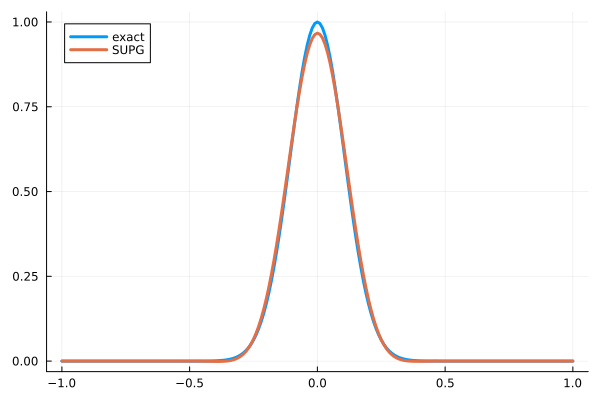

In [164]:
tfinal = 40
u = exp(A * tfinal) * u0
plot(fe.xn, [exact.(fe.xn, tfinal) P*u], label=["exact" "SUPG"], legend=:topleft)

# Spectrum of the operator

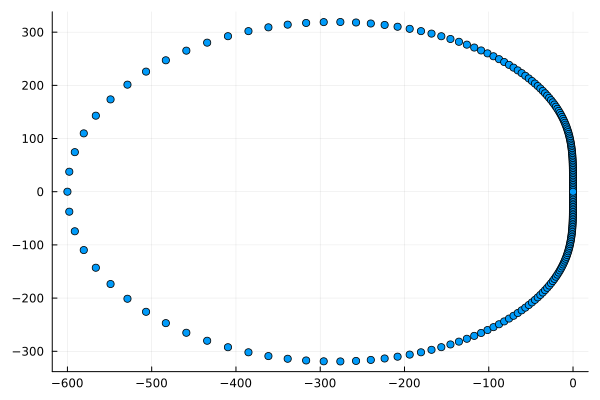

In [165]:
lam = eigvals(A) 
scatter(real.(lam), imag.(lam), legend=:none)

# Demanding problem

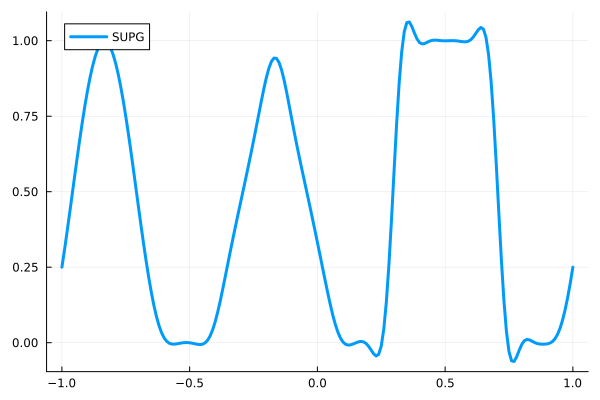

In [166]:
function testfunc(x)
    max(1 - 4*abs.(x+2/3),
        abs.(x) .< .2,
        (2*abs.(x-2/3) .< .5) * cospi(2*(x-2/3)).^2
    )
end

fe, u0, A, P = supg_setup();
u0 = P' * testfunc.(fe.xn)
tfinal = 2.5
u = exp(A * tfinal) * u0
plot(fe.xn, P*u, label="SUPG", legend=:topleft)

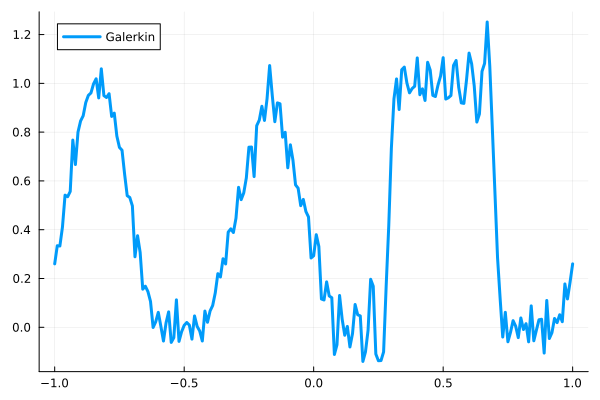

In [168]:
n = 200; h = 2 / n; Pe = abs(wind) * h / (2 * k)
tau = h / (2 * abs(wind)) * (coth(Pe) - 1 / Pe) * 0
fe, u0, A, P = supg_setup();
u0 = P' * testfunc.(fe.xn)
tfinal = 2.5
u = exp(A * tfinal) * u0
plot(fe.xn, P*u, label="Galerkin", legend=:topleft)

# Finite element interfaces: [Deal.II](https://dealii.org)

\begin{gather*}
    v^T F(u) \sim \int_\Omega v \cdot \color{olive}{f_0(u, \nabla u)} + \nabla v \!:\! \color{olive}{f_1(u, \nabla u)} \quad
    v^T J w \sim \int_\Omega \begin{bmatrix} v \\ \nabla v \end{bmatrix}^T \color{teal}{\begin{bmatrix} f_{0,0} & f_{0,1} \\ f_{1,0} & f_{1,1} \end{bmatrix}}
    \begin{bmatrix} w \\ \nabla w \end{bmatrix} \\
    J w = \sum_e \mathcal E_e^T \underbrace{\begin{bmatrix} B_I \\ B_{\nabla} \end{bmatrix}^T
    \begin{bmatrix} I & \\ & \left( \frac{\partial X}{\partial x}\right)^T \end{bmatrix}}_{\texttt{fe\_values}} W_q \color{teal}{\begin{bmatrix} f_{0,0} & f_{0,1} \\ f_{1,0} & f_{1,1} \end{bmatrix}} \underbrace{\begin{bmatrix} I & \\ & \left( \frac{\partial X}{\partial x}\right) \end{bmatrix} \begin{bmatrix} B_I \\ B_{\nabla} \end{bmatrix}}_{\texttt{fe\_values}} \mathcal E_e w_L
\end{gather*}

* Deal.II [step-7](https://dealii.org/developer/doxygen/deal.II/step_7.html)

```python
for e in elems:
    fe_values.reinit(e)
    for q in q_points:
        for i in test_functions:
            for j in trial_functions
                K_e[i,j] += ...
            f_e[i] += ...
    for f in e.faces:
        if f.at_boundary():
            fe_face_values.reinit()
            for q in q_points:
                ...
```

![](https://dealii.org/images/wiki/gallery/Single_layer.jpeg)



# Matrix-free methods

<img src="img/flop-per-byte-2022.svg" />